In [ ]:
# !pip install facenet_pytorch

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from tqdm import tqdm
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.nn.functional as F
from collections import Counter
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm
from facenet_pytorch import MTCNN


In [157]:
BASE_DIR = '/kaggle/input/artifact-images/trainee_dataset' # change this
train_dir = os.path.join(BASE_DIR, 'train')
test_dir = os.path.join(BASE_DIR, 'test')

# Converting to dataframe for easier handling in processing images
def images_to_dataframe(dir_path):
    def get_label(filename):
        return int(filename.split('_')[-1].split('.')[0])
    
    files = os.listdir(dir_path)

    return pd.DataFrame({
        'filename': files,
        'label': [get_label(f) for f in files]
    })
train_df = images_to_dataframe(train_dir)
test_df = images_to_dataframe(test_dir)
train_df.head()

,filename,label
0,image_00130_1.png,1
1,image_00785_1.png,1
2,image_00878_0.png,0
3,image_00258_1.png,1
4,image_00889_1.png,1


### EDA

Checking for class imbalance

Images with artifacts labeled as 0 and artifactless as 1 correspondingly

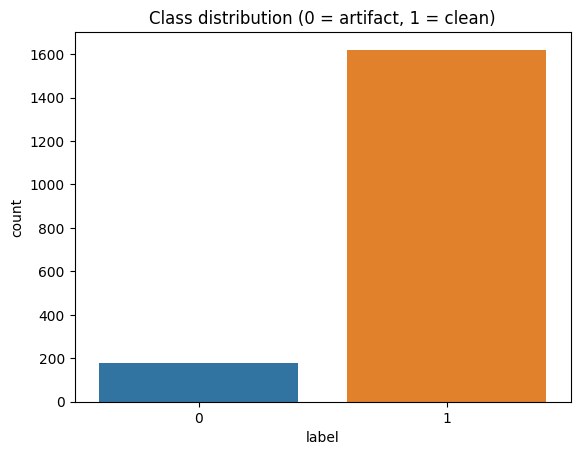

Class distribution:
label
1    1620
0     180
Name: count, dtype: int64
Ratio (clean/artifact): 9.00


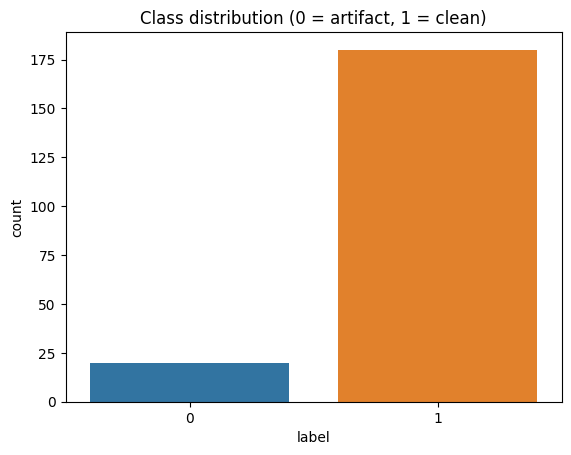

Class distribution:
label
1    180
0     20
Name: count, dtype: int64
Ratio (clean/artifact): 9.00


In [37]:
def plot_class_distribution(df):
    sns.countplot(x="label", data=df)
    plt.title("Class distribution (0 = artifact, 1 = clean)")
    plt.show()

    class_counts = df['label'].value_counts()
    print("Class distribution:")
    print(class_counts)
    print(f"Ratio (clean/artifact): {class_counts[1] / class_counts[0]:.2f}")

plot_class_distribution(train_df)
plot_class_distribution(test_df)

As we can see, there is majority of artifactless images with ratio 1:9

In [4]:
def check_shapes(df, dir):
    '''
    Checking possible shapes in dataset
    '''
    shapes = []
    for fname in df["filename"][:100]: # take sample for speed
        img = cv2.imread(os.path.join(dir, fname))
        shapes.append(img.shape)

    shape_counts = Counter(shapes)
    print("Image shapes:")
    for k, v in shape_counts.items():
        print(f"{k}: {v} images")

check_shapes(train_df, train_dir)
check_shapes(test_df, test_dir)

Image shapes:
(1024, 1024, 3): 100 images
Image shapes:
(1024, 1024, 3): 100 images


All images are with shape 1024x1024 rgb

In [158]:
def show_samples(df, dir, n=2):
    '''
    Show some photos from dataset
    '''
    fig, axs = plt.subplots(2, n, figsize=(8, 6))
    for i in range(n):
        img0 = cv2.imread(os.path.join(dir, df[df.label == 0].iloc[i].filename))
        img1 = cv2.imread(os.path.join(dir, df[df.label == 1].iloc[i].filename))
        axs[0, i].imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))
        axs[1, i].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    axs[0, 0].set_ylabel("Label 0 (arfifact)")
    axs[1, 0].set_ylabel("Label 1 (arfifactless)")
    plt.tight_layout()
    plt.show()

Example of images from datasets

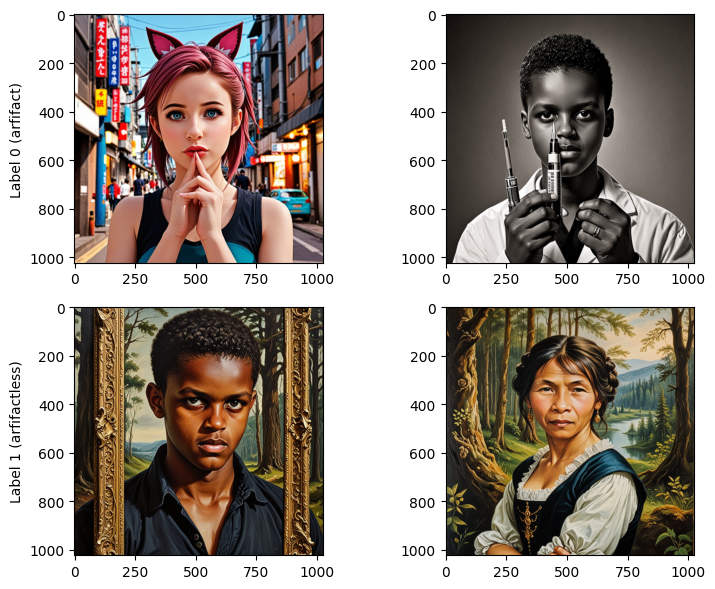

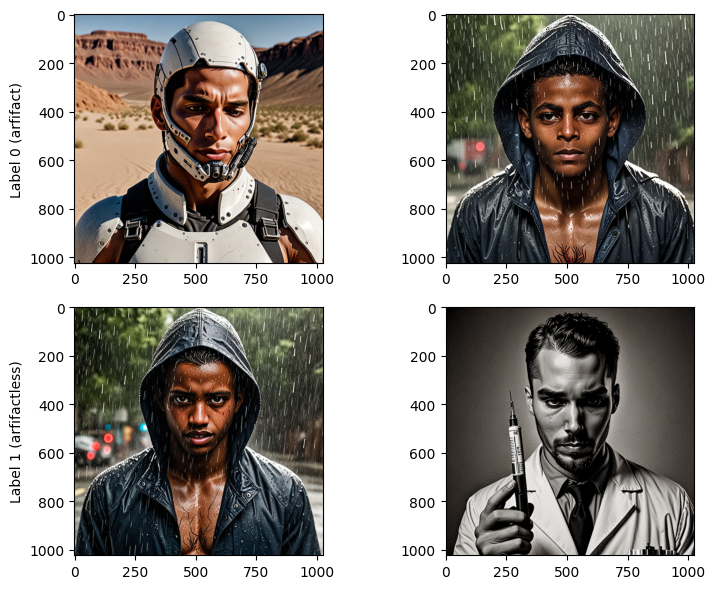

In [39]:
show_samples(train_df, train_dir)
show_samples(test_df, test_dir)

Additionally, checking the RGB color mean and std on training dataset for further standardization because AI generated images have high range of colors and colorful patterns

In [ ]:
# Mean and std are already calculated and commented since it takes some time

# def compute_rgb_stats(dir):
#     means, stds = [], []
#     image_filenames = os.listdir(dir)
#     for fname in image_filenames:
#         img = cv2.imread(os.path.join(dir, fname))  # BGR
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img = img.astype(np.float32) / 255.0  # scale to [0, 1]

#         means.append(np.mean(img, axis=(0, 1)))  # mean per channel
#         stds.append(np.std(img, axis=(0, 1)))    # std per channel

#     dataset_mean = np.mean(means, axis=0)
#     dataset_std = np.mean(stds, axis=0)
    
#     return dataset_mean, dataset_std
# mean, std = compute_rgb_stats(train_dir)
# print(f'Mean is: {mean}, std is: {std}')

# Mean is: [0.43102694 0.36912292 0.31563106], std is: [0.2624569  0.23488636 0.22096337]

In [159]:
def denormalize_tensor(img_tensor, device='cpu'):
    """
    Denormalizes a tensor image of shape [3, H, W] and returns a NumPy array of shape [H, W, 3] in [0, 1] range.
    """
    mean = torch.tensor([0.43102694, 0.36912292, 0.31563106], device=device).view(3, 1, 1)
    std = torch.tensor([0.2624569, 0.23488636, 0.22096337], device=device).view(3, 1, 1)

    img_tensor = img_tensor * std + mean
    img_tensor = torch.clamp(img_tensor, 0, 1)
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()  # Convert to [H, W, C] format
    return img_np

def visualize_dataset_images(dataset, num_images=5, device='cpu'):
    """
    Visualizes images from a dataset by undoing normalization. Shows num_images from the dataset.
    """
    fig, axes = plt.subplots(1, num_images, figsize=(4 * num_images, 4))
    if num_images == 1:
        axes = [axes]

    for i in range(num_images):
        img, label = dataset[i]
        img = img.to(device) if device else img
        img = denormalize_tensor(img, device=device)

        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


def plot_train_results(train_losses, test_losses, train_f1, test_f1):
    '''
    Function for plot losses and scores
    '''
    figure, axis = plt.subplots(2, 2, figsize=(12, 8))
    
    axis[0, 0].plot(range(epochs), train_losses)
    axis[0, 0].set_title("Train loss")
    axis[0, 0].set_xlabel("Epochs")
    axis[0, 0].set_ylabel("Loss")
    axis[0, 0].grid(True)
    
    axis[0, 1].plot(range(epochs), test_losses, color='orange', label="Test loss")
    axis[0, 1].set_title("Test loss")
    axis[0, 1].set_xlabel("Epochs")
    axis[0, 1].set_ylabel("Loss")
    axis[0, 1].grid(True)
    
    axis[1, 0].plot(range(epochs), train_f1)
    axis[1, 0].set_title("Train micro f1")
    axis[1, 0].set_xlabel("Epochs")
    axis[1, 0].set_ylabel("")
    axis[1, 0].grid(True)
    
    axis[1, 1].plot(range(epochs), test_f1, color='orange', label="Test micro f1")
    axis[1, 1].set_title("Test micro f1")
    axis[1, 1].set_title("Epochs")
    axis[1, 1].set_title("")
    axis[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()


### First method
Train model on full images

In [6]:
class FullImageDataset(Dataset):
    '''
    Dataset class for images, apply transformations if passed
    '''
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        img = cv2.imread(os.path.join(self.img_dir, row.filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(image=img)["image"]
        return img, row.label
    

train_transform = A.Compose([
    A.Resize(224, 224),  # EfficientNet will be with pre-trained weights on ImageNet where size of images was 224x224
    A.Rotate(30),
    A.HorizontalFlip(),
    A.Normalize(mean=[0.43102694, 0.36912292, 0.31563106], std=[0.2624569, 0.23488636, 0.22096337]),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.43102694, 0.36912292, 0.31563106], std=[0.2624569, 0.23488636, 0.22096337]),
    ToTensorV2()
])

train_dataset = FullImageDataset(train_df, train_dir, train_transform)
test_dataset = FullImageDataset(test_df, test_dir, test_transform)


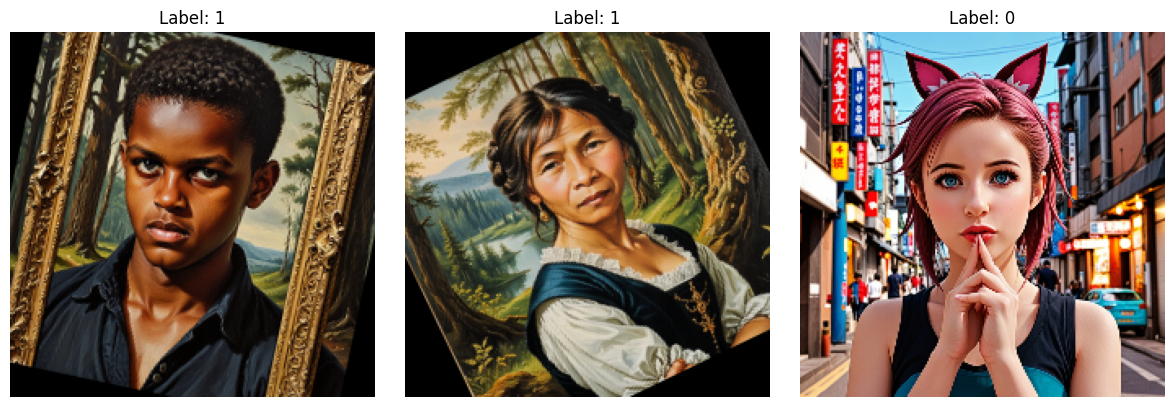

In [161]:
visualize_dataset_images(train_dataset, num_images=3)

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [28]:
class EfficientNetB7(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        self.model = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.IMAGENET1K_V1)

        
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)

        # Freeze all layers to avoid training the entire backbone (transfer learning)
        # I was trying to freeze or not layers and check what will better perform and it came out that not freezing performs better
        # for param in self.model.parameters():
        #     param.requires_grad = False

        # for param in self.model.features[-3:].parameters():  # Last 3 feature blocks
        #     param.requires_grad = True

        # Ensure the classifier head is trainable
        for param in self.model.classifier.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.model(x)

class FocalLoss(nn.Module):
    def __init__(self, alpha=9, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha    # Balancing factor for positive vs negative examples
        self.gamma = gamma    # Focusing parameter to down-weight easy examples
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Compute log probabilities (after softmax)
        log_probs = F.log_softmax(inputs, dim=1)

        # Get softmax probabilities
        probs = torch.exp(log_probs)

        # Convert target indices to one-hot encoding
        targets_one_hot = F.one_hot(targets, num_classes=inputs.shape[1]).float()

        # Compute the focal weight for each class
        focal_weight = (1 - probs) ** self.gamma

        # Apply the focal loss formula
        loss = -self.alpha * focal_weight * log_probs * targets_one_hot

        # Reduce loss according to the selected mode
        if self.reduction == 'mean':
            return loss.sum(dim=1).mean()  # Average over batch
        elif self.reduction == 'sum':
            return loss.sum()  # Sum over all elements
        else:
            return loss


In [ ]:
device = torch.device('cuda')

In [29]:
model_full = EfficientNetB7(num_classes=2).to(device)
criterion = FocalLoss()
optimizer = optim.AdamW(model_full.parameters(), lr=0.001, weight_decay=1e-4)

I was trying different losses CrossEntropy (assuming weights with ratio 1 to 9), BCEWithLogits, FocalLoss but the best was FocalLoss <br>

In [30]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    prog_bar = tqdm(dataloader, desc="Training", leave=True)
    for images, labels in prog_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        prog_bar.set_postfix({'Train batch loss': loss.item()})
        
    micro_f1 = f1_score(all_labels, all_preds, average='micro')
    return running_loss / len(dataloader), micro_f1

def test(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    prog_bar = tqdm(dataloader, desc="Testing", leave=True)
    with torch.no_grad():
        for images, labels in prog_bar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            # Get predictions
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            prog_bar.set_postfix({'Test batch loss': loss.item()})
            
    micro_f1 = f1_score(all_labels, all_preds, average='micro')
    return running_loss / len(dataloader), micro_f1


# Uncomment for training procces or move into new cell
    
# train_losses, test_losses = [], []
# train_f1, test_f1 = [], []

# epochs = 10
# for epoch in range(epochs):
#     print(f"Epoch {epoch+1}/{epochs}")
    
#     # Train phase
#     train_loss, train_micro_f1 = train(model_full, train_dataloader, criterion, optimizer, device)
#     print(f"Average train loss: {train_loss:.4f}, Micro F1: {train_micro_f1:.4f}")
#     train_losses.append(train_loss)
#     train_f1.append(train_micro_f1)
    
#     # Validation phase
#     test_loss, test_micro_f1 = test(model_full, test_dataloader, criterion, device)
#     print(f"Average test loss: {test_loss:.4f}, Micro F1: {test_micro_f1:.4f}")
#     test_losses.append(test_loss)
#     test_f1.append(test_micro_f1)

Epoch 1/10


Training: 100%|██████████| 57/57 [01:38<00:00,  1.72s/it, Train batch loss=1.33] 


Average train loss: 0.9551, Micro F1: 0.8856


Testing: 100%|██████████| 7/7 [00:08<00:00,  1.27s/it, Test batch loss=0.672]


Average test loss: 0.6245, Micro F1: 0.9100
Epoch 2/10


Training: 100%|██████████| 57/57 [01:38<00:00,  1.72s/it, Train batch loss=1.55] 


Average train loss: 0.7885, Micro F1: 0.9006


Testing: 100%|██████████| 7/7 [00:09<00:00,  1.29s/it, Test batch loss=0.774]


Average test loss: 0.6792, Micro F1: 0.9000
Epoch 3/10


Training: 100%|██████████| 57/57 [01:37<00:00,  1.72s/it, Train batch loss=0.196]


Average train loss: 0.6050, Micro F1: 0.9128


Testing: 100%|██████████| 7/7 [00:08<00:00,  1.26s/it, Test batch loss=0.187]


Average test loss: 0.4700, Micro F1: 0.9500
Epoch 4/10


Training: 100%|██████████| 57/57 [01:37<00:00,  1.72s/it, Train batch loss=0.222]


Average train loss: 0.5386, Micro F1: 0.9167


Testing: 100%|██████████| 7/7 [00:08<00:00,  1.28s/it, Test batch loss=0.983]


Average test loss: 0.7432, Micro F1: 0.8750
Epoch 5/10


Training: 100%|██████████| 57/57 [01:38<00:00,  1.73s/it, Train batch loss=0.0493]


Average train loss: 0.4619, Micro F1: 0.9233


Testing: 100%|██████████| 7/7 [00:08<00:00,  1.28s/it, Test batch loss=0.151] 


Average test loss: 0.3736, Micro F1: 0.9550
Epoch 6/10


Training: 100%|██████████| 57/57 [01:38<00:00,  1.74s/it, Train batch loss=1.54] 


Average train loss: 0.4615, Micro F1: 0.9439


Testing: 100%|██████████| 7/7 [00:09<00:00,  1.29s/it, Test batch loss=0.075]


Average test loss: 0.5779, Micro F1: 0.9350
Epoch 7/10


Training: 100%|██████████| 57/57 [01:38<00:00,  1.73s/it, Train batch loss=0.251] 


Average train loss: 0.3929, Micro F1: 0.9567


Testing: 100%|██████████| 7/7 [00:08<00:00,  1.28s/it, Test batch loss=0.912]


Average test loss: 0.5967, Micro F1: 0.9300
Epoch 8/10


Training: 100%|██████████| 57/57 [01:38<00:00,  1.72s/it, Train batch loss=0.374] 


Average train loss: 0.4841, Micro F1: 0.9283


Testing: 100%|██████████| 7/7 [00:08<00:00,  1.28s/it, Test batch loss=0.448]


Average test loss: 0.4052, Micro F1: 0.9550
Epoch 9/10


Training: 100%|██████████| 57/57 [01:38<00:00,  1.73s/it, Train batch loss=1.83]  


Average train loss: 0.4384, Micro F1: 0.9478


Testing: 100%|██████████| 7/7 [00:09<00:00,  1.29s/it, Test batch loss=0.0624]


Average test loss: 0.3925, Micro F1: 0.9500
Epoch 10/10


Training: 100%|██████████| 57/57 [01:38<00:00,  1.72s/it, Train batch loss=0.0681]


Average train loss: 0.3335, Micro F1: 0.9628


Testing: 100%|██████████| 7/7 [00:08<00:00,  1.28s/it, Test batch loss=0.0653]

Average test loss: 0.2932, Micro F1: 0.9700


The model was trained on 10 epochs due to time computation and the best result of micro F1 score (TP / FP + FN) was 97% on test set

In [31]:
torch.save(model_full.state_dict(), "effnetv2_full_img.pth")

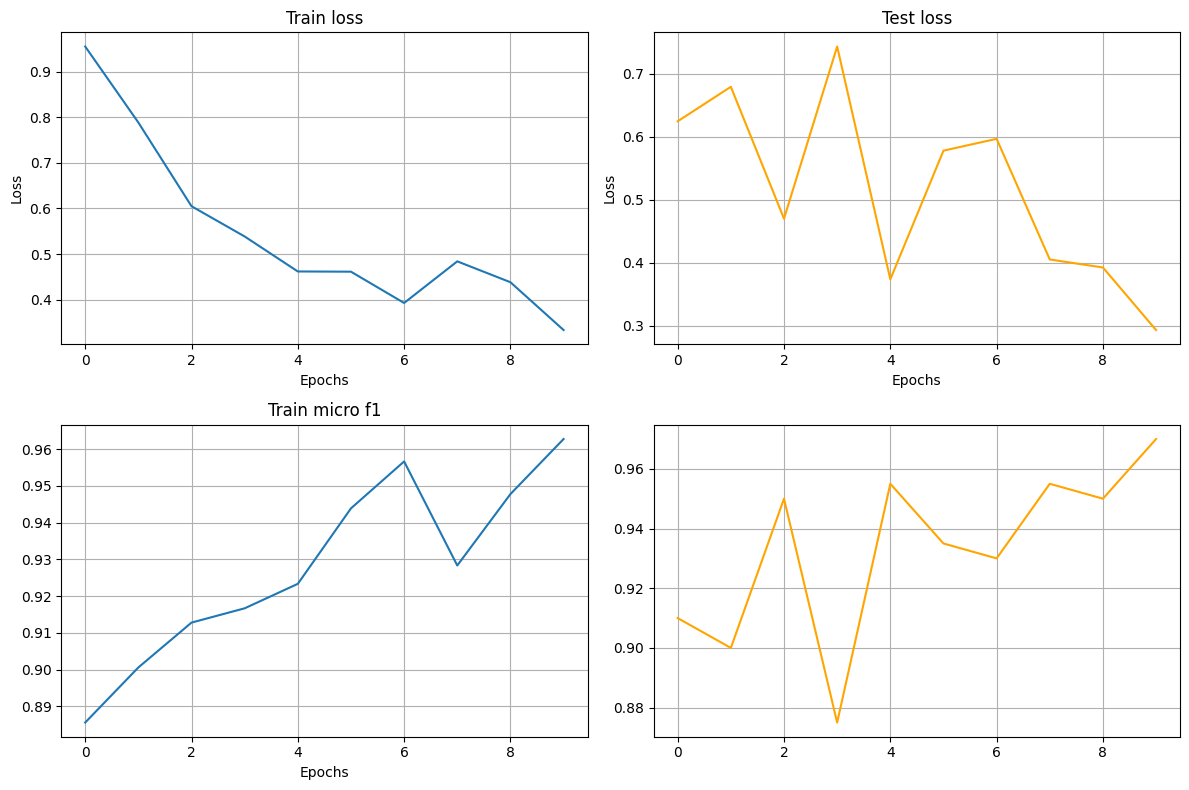

In [33]:
plot_train_results(train_losses, test_losses, train_f1, test_f1)

### Second method <br>
Training same model but only on croped faces

In [121]:
class FaceExtractor:
    def __init__(self, device):
        self.device = device
        self.mtcnn = MTCNN(keep_all=True, device=self.device)

    def extract_face(self, image: np.ndarray) -> np.ndarray:
        # Convert input image from BGR (OpenCV default) to RGB (expected by MTCNN)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Detect all faces in the image
        faces, probs = self.mtcnn.detect(image_rgb)
        
        if faces is not None:
            # If any faces were detected, extract the first one
            x1, y1, x2, y2 = faces[0].astype(int)

            # Clamp coordinates to valid image range to avoid indexing errors
            x1, y1, x2, y2 = max(x1, 0), max(y1, 0), min(x2, image.shape[1]), min(y2, image.shape[0])

            # Crop and return the face region from the original RGB image
            face_crop_rgb = image_rgb[y1:y2, x1:x2]
            return face_crop_rgb
        
        return image_rgb

class FaceImageDataset(Dataset):
    def __init__(self, df, img_dir, transform, device):
        self.df = df.reset_index(drop=True)  
        self.img_dir = img_dir            
        self.transform = transform          
        self.device = device                 
        self.extractor = FaceExtractor(device=self.device)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img = cv2.imread(os.path.join(self.img_dir, row.filename))
        
        # Extract face from the image using MTCNN
        face = self.extractor.extract_face(img)

        face = self.transform(image=face)['image']
        face = face.to(self.device)
        return face, row.label

    def __len__(self):
        return len(self.df)


face_train_transform = A.Compose([
    A.Resize(224, 224),  # EfficientNet will be with pre-trained weights on ImageNet where size of images was 224x224
    A.HorizontalFlip(),
    A.Normalize(mean=[0.43102694, 0.36912292, 0.31563106], std=[0.2624569, 0.23488636, 0.22096337]),
    ToTensorV2()
])


In [126]:
train_face_dataset = FaceImageDataset(train_df, train_dir, transform=face_train_transform, device=device)
test_face_dataset = FaceImageDataset(test_df, test_dir, transform=test_transform, device=device)

train_face_dataloader = DataLoader(train_face_dataset, batch_size=32, shuffle=True)
test_face_dataloader = DataLoader(test_face_dataset, batch_size=32, shuffle=False)

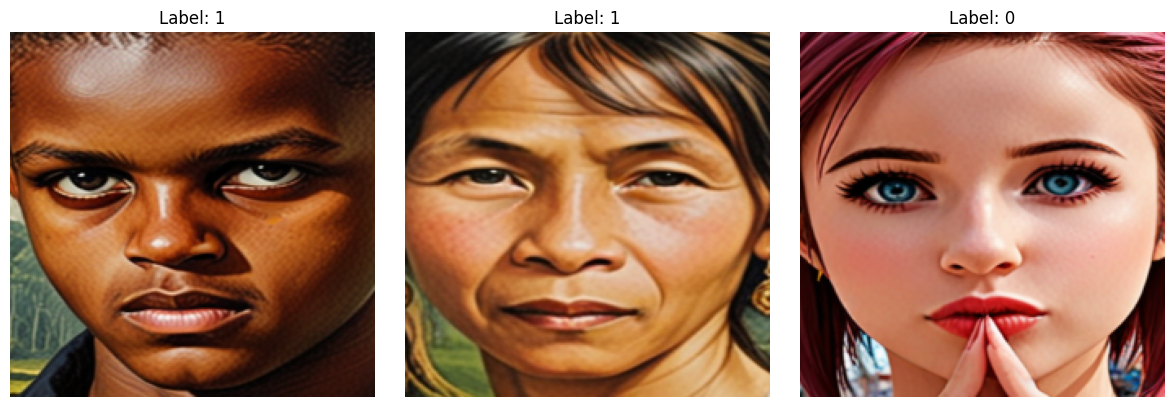

In [162]:
visualize_dataset_images(train_face_dataset, num_images = 3)

In [130]:
model_face = EfficientNetB7().to(device)
criterion = FocalLoss()
optimizer = optim.AdamW(model_face.parameters(), lr=0.001, weight_decay=1e-4)

In [131]:
# train_losses, test_losses = [], []
# train_f1, test_f1 = [], []

# epochs = 10
# for epoch in range(epochs):
#     print(f"Epoch {epoch+1}/{epochs}")
    
#     train_loss, train_micro_f1 = train(model_face, train_face_dataloader, criterion, optimizer, device)
#     print(f"Average train loss: {train_loss:.4f}, Micro F1: {train_micro_f1:.4f}")
#     train_losses.append(train_loss)
#     train_f1.append(train_micro_f1)
    
#     test_loss, test_micro_f1 = test(model_face, test_face_dataloader, criterion, device)
#     print(f"Average test loss: {test_loss:.4f}, Micro F1: {test_micro_f1:.4f}")
#     test_losses.append(test_loss)
#     test_f1.append(test_micro_f1)

Epoch 1/10


Training: 100%|██████████| 57/57 [05:37<00:00,  5.92s/it, Train batch loss=0.18] 


Average train loss: 0.8098, Micro F1: 0.8961


Testing: 100%|██████████| 7/7 [00:36<00:00,  5.18s/it, Test batch loss=0.217]


Average test loss: 0.6360, Micro F1: 0.9100
Epoch 2/10


Training: 100%|██████████| 57/57 [05:37<00:00,  5.92s/it, Train batch loss=0.243] 


Average train loss: 0.4847, Micro F1: 0.9356


Testing: 100%|██████████| 7/7 [00:36<00:00,  5.15s/it, Test batch loss=0.457]


Average test loss: 0.4398, Micro F1: 0.9350
Epoch 3/10


Training: 100%|██████████| 57/57 [05:36<00:00,  5.91s/it, Train batch loss=0.521] 


Average train loss: 0.3591, Micro F1: 0.9589


Testing: 100%|██████████| 7/7 [00:36<00:00,  5.17s/it, Test batch loss=1.13] 


Average test loss: 1.0742, Micro F1: 0.8800
Epoch 4/10


Training: 100%|██████████| 57/57 [05:35<00:00,  5.89s/it, Train batch loss=0.184] 


Average train loss: 0.3568, Micro F1: 0.9556


Testing: 100%|██████████| 7/7 [00:36<00:00,  5.15s/it, Test batch loss=0.103]


Average test loss: 0.6130, Micro F1: 0.9500
Epoch 5/10


Training: 100%|██████████| 57/57 [05:35<00:00,  5.89s/it, Train batch loss=0.282] 


Average train loss: 0.2795, Micro F1: 0.9600


Testing: 100%|██████████| 7/7 [00:36<00:00,  5.16s/it, Test batch loss=0.0914]


Average test loss: 0.4905, Micro F1: 0.9400
Epoch 6/10


Training: 100%|██████████| 57/57 [05:36<00:00,  5.91s/it, Train batch loss=0.208] 


Average train loss: 0.3602, Micro F1: 0.9472


Testing: 100%|██████████| 7/7 [00:36<00:00,  5.17s/it, Test batch loss=0.362]


Average test loss: 0.4549, Micro F1: 0.9550
Epoch 7/10


Training: 100%|██████████| 57/57 [05:36<00:00,  5.91s/it, Train batch loss=0.0562]


Average train loss: 0.2459, Micro F1: 0.9639


Testing: 100%|██████████| 7/7 [00:36<00:00,  5.21s/it, Test batch loss=0.0222]


Average test loss: 0.4913, Micro F1: 0.9450
Epoch 8/10


Training: 100%|██████████| 57/57 [05:39<00:00,  5.96s/it, Train batch loss=0.108]  


Average train loss: 0.2247, Micro F1: 0.9717


Testing: 100%|██████████| 7/7 [00:35<00:00,  5.14s/it, Test batch loss=0.458]


Average test loss: 0.4798, Micro F1: 0.9300
Epoch 9/10


Training: 100%|██████████| 57/57 [05:35<00:00,  5.88s/it, Train batch loss=0.355] 


Average train loss: 0.1917, Micro F1: 0.9739


Testing: 100%|██████████| 7/7 [00:35<00:00,  5.14s/it, Test batch loss=0.115]


Average test loss: 0.6093, Micro F1: 0.9100
Epoch 10/10


Training: 100%|██████████| 57/57 [05:35<00:00,  5.88s/it, Train batch loss=0.031]  


Average train loss: 0.1217, Micro F1: 0.9817


Testing: 100%|██████████| 7/7 [00:35<00:00,  5.13s/it, Test batch loss=0.119]

Average test loss: 0.6212, Micro F1: 0.9450


In [132]:
torch.save(model_face.state_dict(), "effnetv2_face_img.pth")

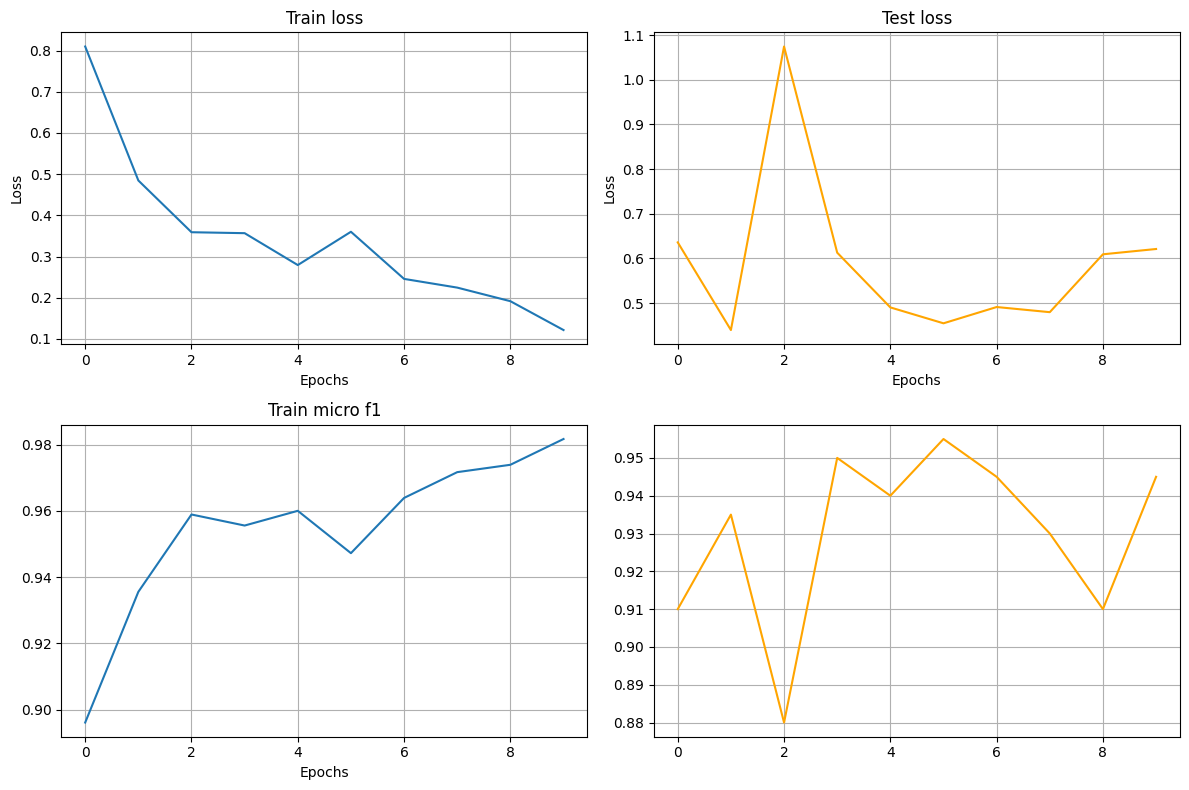

In [133]:
plot_train_results(train_losses, test_losses, train_f1, test_f1)

### Advanced
Making predictions using both trained models

In [144]:
class EnsembleDataset(Dataset):
    '''
    Dataset class for both full and face images
    '''
    def __init__(self, df, img_dir, transform, device):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.device = device
        self.face_extractor = FaceExtractor(device=device)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = os.path.join(self.img_dir, row.filename)
        image = cv2.imread(path)

        full_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        face_rgb = self.face_extractor.extract_face(image)

        full_tensor = self.transform(image=full_rgb)['image'].to(self.device)
        face_tensor = self.transform(image=face_rgb)['image'].to(self.device)

        return full_tensor, face_tensor, row.label

    def __len__(self):
        return len(self.df)
    def __len__(self):
        return len(self.df)

def test_ensemble(full_model, face_model, dataloader, device):
    '''
    Evaluates per class acuraccy and retuns labels with predictions for F1 score
    '''
    all_preds = []
    all_labels = []

    full_model.eval()
    face_model.eval()

    with torch.no_grad():
        for full_x, face_x, labels in tqdm(dataloader):
            full_x = full_x.to(device)
            face_x = face_x.to(device)
            labels = labels.to(device)

            # Get logits
            full_logits = full_model(full_x)
            face_logits = face_model(face_x)

            # Softmax probabilities
            full_probs = F.softmax(full_logits, dim=1)
            face_probs = F.softmax(face_logits, dim=1)

            # Weighted average ensemble
            ensemble_probs = full_probs * 0.7 + face_probs * 0.3

            preds = ensemble_probs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate per-class accuracy
    artifact_mask = all_labels == 0
    artifactless_mask = all_labels == 1

    artifact_correct = (all_preds[artifact_mask] == 0).sum()
    artifactless_correct = (all_preds[artifactless_mask] == 1).sum()

    artifact_total = artifact_mask.sum()
    artifactless_total = artifactless_mask.sum()

    artifact_acc = artifact_correct / artifact_total if artifact_total > 0 else 0.0
    artifactless_acc = artifactless_correct / artifactless_total if artifactless_total > 0 else 0.0

    result = {
        "Artifact images (label 0)": artifact_acc,
        "Artifactless images (label 1)": artifactless_acc
    }
    df_result = pd.DataFrame.from_dict(result, orient='index', columns=['accuracy'])
    
    return all_preds, all_labels, df_result

In [145]:
ensemble_dataset = EnsembleDataset(test_df, test_dir, test_transform, device=device)
ensemble_dataloader = DataLoader(dataset=ensemble_dataset, batch_size=32)

full_model = EfficientNetB7(num_classes=2).to(device)
full_model.load_state_dict(torch.load('effnetv2_full_img.pth'))
full_model.eval()

face_model = EfficientNetB7(num_classes=2).to(device)
face_model.load_state_dict(torch.load('effnetv2_face_img.pth'))
face_model.eval()

preds, labels, result = test_ensemble(full_model, face_model, ensemble_dataloader, device)

f1 = f1_score(labels, preds, average='micro')
print(f"Ensemble Micro F1: {f1:.4f}")
print(result)

100%|██████████| 7/7 [00:36<00:00,  5.23s/it]

Ensemble Micro F1: 0.9700
                               accuracy
Artifact images (label 0)           0.7
Artifactless images (label 1)       1.0


### Inference

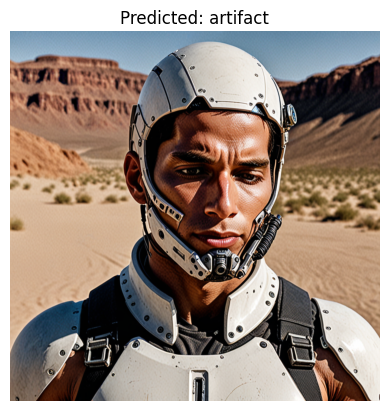

Label 0


In [156]:
class FaceExtractor: # copied code here in order to pass code and not to run code with FaceExtractor cell above
    def __init__(self, device):
        self.device = device
        self.mtcnn = MTCNN(keep_all=True, device=self.device)

    def extract_face(self, image: np.ndarray) -> np.ndarray:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        faces, probs = self.mtcnn.detect(image_rgb)
        if faces is not None:
            x1, y1, x2, y2 = faces[0].astype(int)
            x1, y1, x2, y2 = max(x1, 0), max(y1, 0), min(x2, image.shape[1]), min(y2, image.shape[0])
            face_crop_rgb = image_rgb[y1:y2, x1:x2]
            return face_crop_rgb
        
        return image_rgb

def infer_single_image(image_path, full_model, face_model, device):
    image = cv2.imread(image_path)
    exctractor = FaceExtractor(device)
    full_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    face_image = exctractor.extract_face(image)
    
    transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.43102694, 0.36912292, 0.31563106], std=[0.2624569, 0.23488636, 0.22096337]),
    ToTensorV2()
    ])
    
    full_tensor = transform(image=full_image)['image'].to(device)
    face_tensor = transform(image=face_image)['image'].to(device)
    full_tensor = full_tensor.unsqueeze(0)
    face_tensor = face_tensor.unsqueeze(0)
    
    full_model.eval()
    face_model.eval()

    with torch.no_grad():
        full_logits = full_model(full_tensor)
        face_logits = face_model(face_tensor)

        full_probs = F.softmax(full_logits, dim=1)
        face_probs = F.softmax(face_logits, dim=1)
        ensemble_probs = full_probs * 0.7 + face_probs * 0.3
        pred = ensemble_probs.argmax(dim=1).item()

    plt.imshow(full_image)
    plt.title(f"Predicted: {'artifact' if pred == 0 else 'artifactless'}")
    plt.axis("off")
    plt.show()
    print(f'Label {pred}')
    return pred


full_model = EfficientNetB7(num_classes=2).to(device)
full_model.load_state_dict(torch.load('effnetv2_full_img.pth'))
face_model = EfficientNetB7(num_classes=2).to(device)
face_model.load_state_dict(torch.load('effnetv2_face_img.pth'))
device = torch.device('cuda')

# Change this to your image path
BASE_DIR = '/kaggle/input/artifact-images/trainee_dataset' # change this
test_dir = os.path.join(BASE_DIR, 'test') # change this
img_name = test_df.filename[6] # change this
img_pth = os.path.join(test_dir, img_name) # change this

res = infer_single_image(img_pth, full_model, face_model, device)

So firstly idea was to train on pre-trained model EfficientNetV2m full images with some transformations <br>
I've tried also Vit Transfomer for classification but it performed worse <br>
It does not act bad but I've wanted to try if there is better approach or method <br>
So I decided to extract face from image (detect boxes and crop image) using MTCNN from pytorch since it has option to run on CUDA because it took to much time to run on CPU <br>
Then I've trained and saved effnetv2 model on full images and eggnetv2 model in face images <br>
Having these two trained models I've tested on test set using weighted ensemble <br>
### Results
Best micro F1 on full images was 0.97 and on face images was 0.95 <br>
It is interesting to note that the loss on the trade was decreasing all the time and the F1 was improving rapidly, which cannot be said about the test set. <br> On the test set, it behaved ambiguously, getting better and worse, slowly converging. Perhaps this is due to not very good parameters or a small number of epochs, or perhaps due to the structure of the dataset itself <br>
Ensemble didn't improve results since second model had worse F1 score so that it pulled down first model because enseble was using weighted prediction, so the enseble result still same as in first model if it comes to F1 score (I tried different weights and the more second model influence the worse results) <br>
The prediction for artifactless images is 100% and arifact images is 70% accuracies


#### Further work
I know that there is better options but due to time limitations they were not tested <br>
If I will have more time firstly, I will do better parameters choosing and validating using cross-validation folds on train dataset (I've not done this since training and so it is took to much time even on not few epochs) <br>
Also there is a lot of information that can be extracted from faces so can use it for better classification between arifacts e.g. if there is randomly generated item which corrupts face, fingers or eyes. <br>
There was huge class imbalance 1 to 9 ratio, so probably I can find more suitable ways for handling that <br>
I can also test another models or methods e.g. if there is randomly generated items in incorrect places, they can be detect through another NNs or with classic methods where is sharp change in contrast/pixels <br>
Also in ensemble method can be used randomvoteregressor or another approach instead of simple weighting
